In [13]:
# Modelos usados
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Processamento de dados
import pandas as pd
import numpy as np

# Usado no modelo
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

# Graficos que ilustram o modelo
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
dados = pd.read_csv('dados_filtrados.csv',sep=';').dropna()
dados.head(5)

,vacina_descricao_dose,paciente_idade,paciente_racaCor_valor,paciente_endereco_uf,vacina_categoria_nome,paciente_enumSexoBiologico
0,1ª Dose,38.0,AMARELA,SP,Faixa Etária,M
1,3ª Dose,5.0,BRANCA,RS,Faixa Etária,M
2,1ª Dose,48.0,SEM INFORMACAO,SP,Faixa Etária,M
3,1ª Dose,77.0,SEM INFORMACAO,MG,Faixa Etária,F
4,Reforço,63.0,SEM INFORMACAO,SP,Faixa Etária,M


In [15]:
dados = dados.astype({
    'vacina_descricao_dose' : 'category',
    'paciente_idade' : 'int8',
    'paciente_racaCor_valor' : 'category',
    'paciente_endereco_uf' : 'category',
    'vacina_categoria_nome' : 'category',
    'paciente_enumSexoBiologico' : 'category'
})

In [16]:
dados.paciente_racaCor_valor.value_counts

<bound method IndexOpsMixin.value_counts of 0                 AMARELA
1                  BRANCA
2          SEM INFORMACAO
3          SEM INFORMACAO
4          SEM INFORMACAO
                ...      
1048570            BRANCA
1048571           AMARELA
1048572             PARDA
1048573            BRANCA
1048574           AMARELA
Name: paciente_racaCor_valor, Length: 994907, dtype: category
Categories (6, object): ['AMARELA', 'BRANCA', 'INDIGENA', 'PARDA', 'PRETA', 'SEM INFORMACAO']>

# `Sobre o projeto`:

Com o intuito de entender a aderência vacinal pelo território brasileiro, esse projeto desenvolve maneiras de prever a quantitade de vacinas tomadas por um brasileiro a depender do seu perfil e dados pessoais.

Para atingir tal objetivo, foram desenvolvidos três modelos distintos, cujas precisões e resultados foram comparados a fim de decidir qual o melhor deles para a tarefa proposta. Esses são o `Modelo Logístico`, `Decision Tree` e o `Random Forest`.

Durante o projeto, diferentes iterações foram desenvolvidas a fim de melhorar a precisão das previsões obtidas.

### Pré-processamento dos dados

**Padronização dos dados da coluna `paciente_idade`**

Esse passo é necessário para aumentar a acurácia do modelo pois distribui os dados em um range de média 0 e desvio padrão e 1.

In [17]:
scaler = StandardScaler()
scaler_fit = scaler.fit_transform(dados['paciente_idade'].to_frame())

**Converter variáveis categóricas em variáveis booleanas**

Assim, é possível utilizá-las no modelo de Regressão Logística.
A função `get_dummies()` retorna um `DataFrame` onde, para cada categoria, há uma coluna de valores booleanos que correspondem a existência ou não daquela categoria nas células abaixo.

In [18]:
uf = pd.get_dummies(dados["paciente_endereco_uf"],drop_first=True).reset_index(drop=True)
sexobio = pd.get_dummies(dados["paciente_enumSexoBiologico"],drop_first=True).reset_index(drop=True)
cor = pd.get_dummies(dados["paciente_racaCor_valor"],drop_first=True).reset_index(drop=True)
categoria = pd.get_dummies(dados["vacina_categoria_nome"],drop_first=True).reset_index(drop=True)

FeaturesProcessadas = pd.concat([
    pd.Series(scaler_fit.flatten(), name="Idade do Paciente"),
    uf,
    sexobio,
    cor,
    categoria
    ], axis=1)

FeaturesProcessadas.columns = FeaturesProcessadas.columns.astype(str)


TargetProcessado = dados["vacina_descricao_dose"].reset_index(drop=True)
display(FeaturesProcessadas)

,Idade do Paciente,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,População Privada de Liberdade,Povos Indígenas,Povos e Comunidades Tradicionais,Puérperas,Trabalhadores Industriais,Trabalhadores Portuários,Trabalhadores da Educação,Trabalhadores de Limpeza Urbana,Trabalhadores de Saúde,Trabalhadores de Transporte
0,-0.267260,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-1.912179,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.231201,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.676736,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.978891,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994902,0.729661,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
994903,0.530277,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
994904,-1.114643,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
994905,1.128430,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Separando o banco de dados entre `train` e `test`**

In [19]:
randomState = randint(0,100000)
x_train,x_test = train_test_split(FeaturesProcessadas, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)
y_train,y_test = train_test_split(TargetProcessado, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

### Treinamento dos modelos:

`Modelo Logístico`

In [20]:
modelL = LogisticRegression(class_weight='balanced')
modelL.fit(x_train,y_train)

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

`Random Forest`

In [21]:
modelRF = RandomForestClassifier(class_weight="balanced")
modelRF.fit(x_test, y_test)

RandomForestClassifier(class_weight='balanced')

`Decision Tree`

In [22]:
modelDT = DecisionTreeClassifier(splitter='random', class_weight="balanced")
modelDT.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', splitter='random')

### Resultados

In [23]:
testsResultL = modelL.predict(x_test)  # Modelo Logístico
testsResultRF = modelRF.predict(x_test)  # Random Forest
testsResultDT = modelDT.predict(x_test)  # Decision Tree

`Logistic Regression`

In [24]:
print(classification_report(y_test,testsResultL))

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            1ª Dose       0.35      0.01      0.02     91579
    1ª Dose Dobrada       0.00      0.00      0.00         0
1ª Dose Revacinação       0.00      0.09      0.00       156
         1º Reforço       0.02      0.47      0.04      1368
            2ª Dose       0.31      0.01      0.01     84370
2ª Dose Revacinação       0.00      0.15      0.00       142
         2º Reforço       0.14      0.24      0.17     23942
            3ª Dose       0.04      0.21      0.07      1962
3ª Dose Revacinação       0.00      0.32      0.00        84
         3º Reforço       0.01      0.33      0.02       528
            4ª Dose       0.05      0.65      0.09       472
4ª Dose Revacinação       0.00      0.17      0.00       118
         4º Reforço       0.01      0.96      0.01        52
            5ª Dose       0.00      0.75      0.00        24
5ª Dose Revacinação       0.00      0.38      0.00         8
               Dose    

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


`Random Forest`

In [25]:
print(classification_report(y_test,testsResultRF))

                     precision    recall  f1-score   support

            1ª Dose       0.61      0.30      0.40     91579
1ª Dose Revacinação       0.05      0.93      0.09       156
         1º Reforço       0.10      0.88      0.18      1368
            2ª Dose       0.58      0.28      0.38     84370
2ª Dose Revacinação       0.04      0.96      0.07       142
         2º Reforço       0.25      0.45      0.32     23942
            3ª Dose       0.15      0.80      0.25      1962
3ª Dose Revacinação       0.04      0.99      0.08        84
         3º Reforço       0.08      0.92      0.15       528
            4ª Dose       0.19      0.94      0.31       472
4ª Dose Revacinação       0.05      0.99      0.09       118
         4º Reforço       0.06      1.00      0.11        52
            5ª Dose       0.17      1.00      0.29        24
5ª Dose Revacinação       0.10      1.00      0.19         8
               Dose       0.07      0.84      0.13      2532
     Dose Adicional    

`Decision Tree`

In [26]:
print(classification_report(y_test,testsResultDT))

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

            1ª Dose       0.38      0.13      0.19     91579
    1ª Dose Dobrada       0.00      0.00      0.00         0
1ª Dose Revacinação       0.00      0.06      0.00       156
         1º Reforço       0.04      0.45      0.07      1368
            2ª Dose       0.32      0.12      0.17     84370
2ª Dose Revacinação       0.00      0.05      0.00       142
         2º Reforço       0.13      0.22      0.16     23942
            3ª Dose       0.06      0.37      0.11      1962
3ª Dose Revacinação       0.00      0.02      0.00        84
         3º Reforço       0.01      0.20      0.02       528
            4ª Dose       0.04      0.37      0.07       472
4ª Dose Revacinação       0.00      0.05      0.00       118
         4º Reforço       0.01      0.27      0.02        52
            5ª Dose       0.01      0.12      0.02        24
5ª Dose Revacinação       0.00      0.00      0.00         8
               Dose    

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


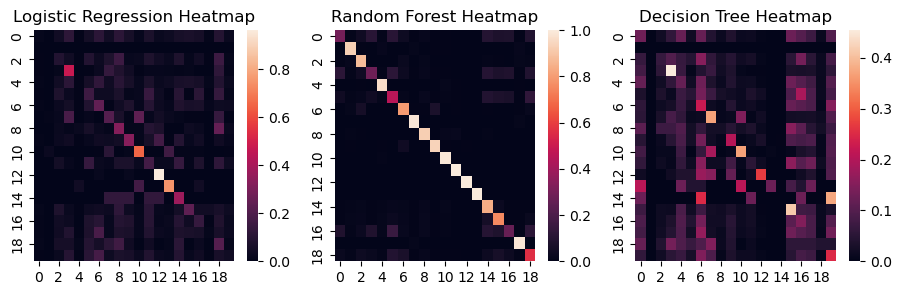

In [27]:
plt.figure(figsize=(11,3))

plt.subplot(131)
sns.heatmap(confusion_matrix(y_test,testsResultL,normalize='true'))
plt.title("Logistic Regression Heatmap")

plt.subplot(132)
sns.heatmap(confusion_matrix(y_test,testsResultRF,normalize='true'))
plt.title("Random Forest Heatmap")

plt.subplot(133)
sns.heatmap(confusion_matrix(y_test,testsResultDT,normalize='true'))
plt.title("Decision Tree Heatmap")
plt.show()

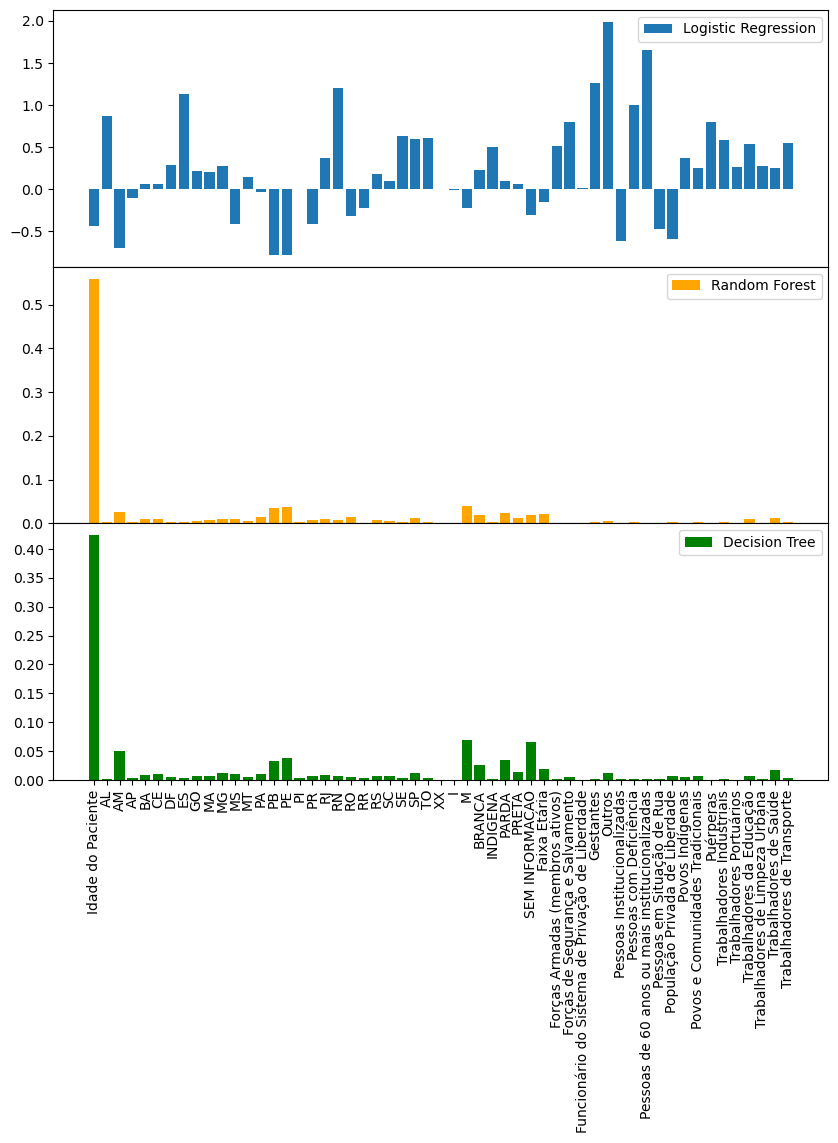

In [28]:
plt.figure(figsize=(10,10))
importance = pd.DataFrame({
    "Logistic Regression" : modelL.coef_[0],
    "Random Forest" : modelRF.feature_importances_,
    "Decision Tree" : modelDT.feature_importances_
},index = x_test.columns)

plt.subplots_adjust(hspace=.0)

plt.subplot(311)
plt.bar(x_test.columns,modelL.coef_[0], label="Logistic Regression")
plt.legend()
plt.xticks([])

plt.subplot(312)
plt.bar(x_test.columns,modelRF.feature_importances_, label="Random Forest", color='orange')
plt.legend()
plt.xticks([])

plt.subplot(313)
plt.bar(x_test.columns,modelDT.feature_importances_, label="Decision Tree",color='green')
plt.legend()
plt.xticks(rotation=90)


plt.show()

___

## 1ª ITERACAO
### SIMPLIFICANDO BANCO DE DADOS
`ITERANDO`: Vamos usar os mesmos métodos em ambos os modelos, pois simplificará a análise de dados e fará com que nossas estimativas sejam  compativeis e aptas a comparacao entre diferentes modelos . 


-A primeira iteração foi feita por meio do Feature Selection

Dado que a coluna `target` possui muitas categorias distintas (19 opções de descrição para a dose da vacina), o modelo tem dificuldade em prever o caso em que o paciente tomou a `3ª dose`.
Para melhorar a quantidade de dados disponíveis, essa coluna irá ser simplificada em rótulos.

In [29]:
display(pd.Series(dados['vacina_descricao_dose'].unique()).to_frame())

,0
0,1ª Dose
1,3ª Dose
2,Reforço
3,2ª Dose
4,Única
5,2º Reforço
6,Dose
7,Revacinação
8,Dose Adicional
9,1º Reforço


A simplificação será feita da seguinte maneira:

1ª Dose : `1ª Dose Revacinação`, `1ª Dose Dobrada`, `1º Reforço`, `Única`, `Reforço`, `Dose` e `Revacinação`\
2ª Dose: `2º Reforço`, `2ª Dose Revacinação`, `Dose Adicional`\
3ª Dose: `3º Reforço` e `3ª Dose Revacinação`\
4ª Dose: `4º Reforço` e `4ª Dose Revacinação`\
5ª Dose: `5ª Dose Revacinação`



In [30]:
TargetProcessado2 = dados["vacina_descricao_dose"].astype('string')

TargetProcessado2.loc[TargetProcessado2.isin(["1ª Dose Revacinação","1ª Dose Dobrada","1º Reforço","Única","Reforço","Dose","Revacinação"])] = "1ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["2º Reforço","2ª Dose Revacinação","Dose Adicional"])] = "2ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["3º Reforço","3ª Dose Revacinação"])] = "3ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["4º Reforço","4ª Dose Revacinação"])] = "4ª Dose"
TargetProcessado2.loc[TargetProcessado2.isin(["5ª Dose Revacinação"])] = "5ª Dose"

TargetProcessado2 = TargetProcessado2.astype('category')

In [31]:
(TargetProcessado2.value_counts(normalize=True)*100).round(2)

vacina_descricao_dose
1ª Dose    61.81
2ª Dose    37.10
3ª Dose     0.87
4ª Dose     0.22
5ª Dose     0.01
Name: proportion, dtype: float64

**Separando a nova coluna `Target` entre `train` e `test`**

In [32]:
y_train,y_test = train_test_split(TargetProcessado2, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

### Treinamento dos modelos:

`Modelo Logístico`

In [33]:
modelL = LogisticRegression(class_weight='balanced')
modelL.fit(x_train,y_train)

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

`Random Forest`

In [34]:
modelRF = RandomForestClassifier(class_weight="balanced")
modelRF.fit(x_test, y_test)

RandomForestClassifier(class_weight='balanced')

`Decision Tree`

In [35]:
modelDT = DecisionTreeClassifier(splitter='random', class_weight="balanced")
modelDT.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', splitter='random')

### Resultados

In [36]:
testsResultL = modelL.predict(x_test)  # Modelo Logístico
testsResultRF = modelRF.predict(x_test)  # Random Forest
testsResultDT = modelDT.predict(x_test)  # Decision Tree

`Logistic Regression`

In [37]:
print(classification_report(y_test,testsResultL))

              precision    recall  f1-score   support

     1ª Dose       0.63      0.36      0.46    184111
     2ª Dose       0.39      0.35      0.37    111114
     3ª Dose       0.02      0.47      0.04      2574
     4ª Dose       0.03      0.59      0.05       642
     5ª Dose       0.00      0.72      0.00        32

    accuracy                           0.36    298473
   macro avg       0.21      0.50      0.18    298473
weighted avg       0.53      0.36      0.42    298473



`Random Forest`

In [38]:
print(classification_report(y_test,testsResultRF))

              precision    recall  f1-score   support

     1ª Dose       0.75      0.59      0.66    184111
     2ª Dose       0.52      0.59      0.55    111114
     3ª Dose       0.12      0.92      0.21      2574
     4ª Dose       0.11      0.96      0.19       642
     5ª Dose       0.14      1.00      0.25        32

    accuracy                           0.60    298473
   macro avg       0.33      0.81      0.37    298473
weighted avg       0.66      0.60      0.62    298473



`Decision Tree`

In [39]:
print(classification_report(y_test,testsResultDT))

              precision    recall  f1-score   support

     1ª Dose       0.63      0.43      0.51    184111
     2ª Dose       0.38      0.45      0.41    111114
     3ª Dose       0.04      0.44      0.07      2574
     4ª Dose       0.02      0.32      0.03       642
     5ª Dose       0.00      0.06      0.01        32

    accuracy                           0.44    298473
   macro avg       0.21      0.34      0.21    298473
weighted avg       0.53      0.44      0.47    298473



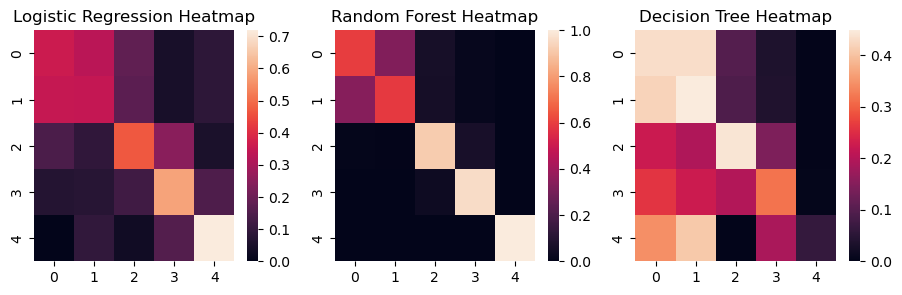

In [40]:
plt.figure(figsize=(11,3))

plt.subplot(131)
sns.heatmap(confusion_matrix(y_test,testsResultL,normalize='true'))
plt.title("Logistic Regression Heatmap")

plt.subplot(132)
sns.heatmap(confusion_matrix(y_test,testsResultRF,normalize='true'))
plt.title("Random Forest Heatmap")

plt.subplot(133)
sns.heatmap(confusion_matrix(y_test,testsResultDT,normalize='true'))
plt.title("Decision Tree Heatmap")
plt.show()

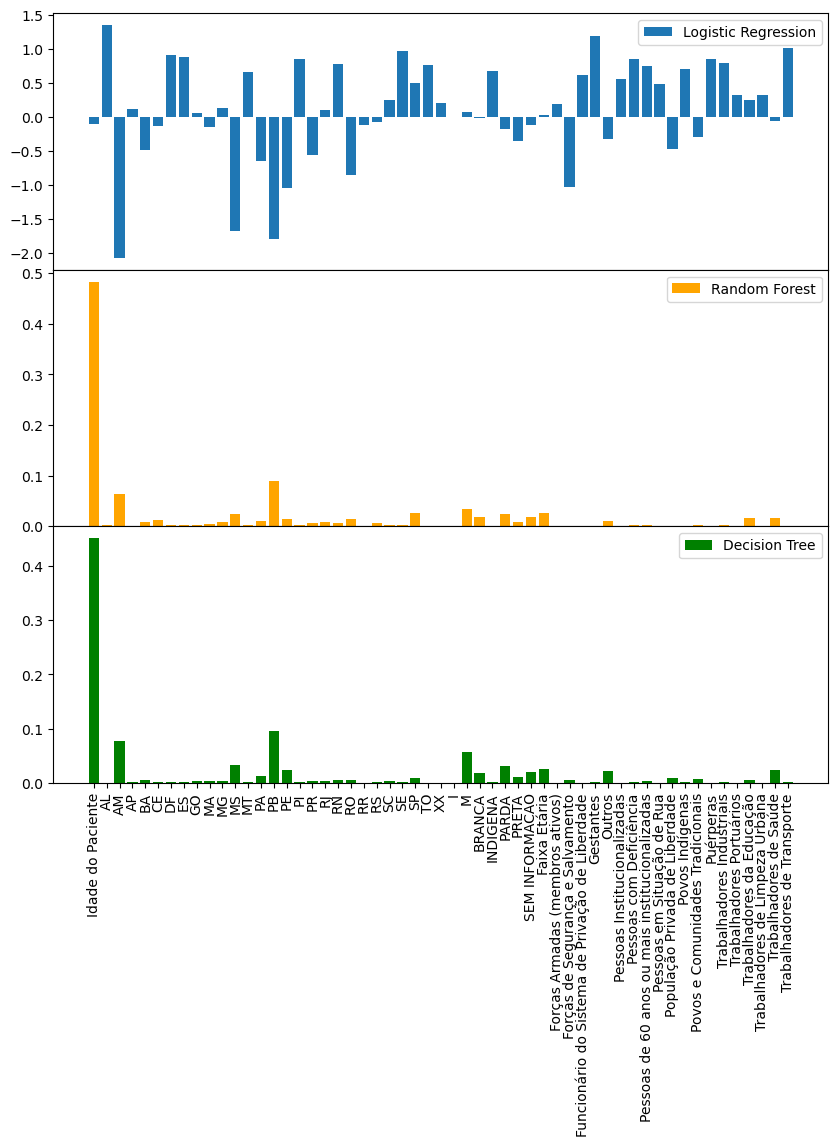

In [41]:
plt.figure(figsize=(10,10))
importance = pd.DataFrame({
    "Logistic Regression" : modelL.coef_[0],
    "Random Forest" : modelRF.feature_importances_,
    "Decision Tree" : modelDT.feature_importances_
},index = x_test.columns)

plt.subplots_adjust(hspace=.0)

plt.subplot(311)
plt.bar(x_test.columns,modelL.coef_[0], label="Logistic Regression")
plt.legend()
plt.xticks([])

plt.subplot(312)
plt.bar(x_test.columns,modelRF.feature_importances_, label="Random Forest", color='orange')
plt.legend()
plt.xticks([])

plt.subplot(313)
plt.bar(x_test.columns,modelDT.feature_importances_, label="Decision Tree",color='green')
plt.legend()
plt.xticks(rotation=90)


plt.show()

___
### `2ª ITERACAO`:

Agora, a coluna foi definida entre os valores `True` e `False` para se o paciente tomou a partir da 2ª dose da vacina.
A partir dessa nova analise feita, foi possivel chegar em resultados mais precisos.


In [42]:
TargetProcessado3 = TargetProcessado2.isin(["2ª Dose","3ª Dose","4ª Dose","5ª Dose"])
print(TargetProcessado3.value_counts(normalize=True))

vacina_descricao_dose
False    0.618053
True     0.381947
Name: proportion, dtype: float64


In [43]:
y_train,y_test = train_test_split(TargetProcessado3, test_size=.3 , train_size=.7 , shuffle=True, random_state=randomState)

`Modelo Logístico`

In [44]:
modelL = LogisticRegression(class_weight='balanced')
modelL.fit(x_train,y_train)

c:\Users\windows\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

`Random Forest`

In [45]:
modelRF = RandomForestClassifier(class_weight="balanced")
modelRF.fit(x_test, y_test)

RandomForestClassifier(class_weight='balanced')

`Decision Tree`

In [46]:
modelDT = DecisionTreeClassifier(splitter='random', class_weight="balanced")
modelDT.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', splitter='random')

### Resultados

In [47]:
testsResultL = modelL.predict(x_test)  # Modelo Logístico
testsResultRF = modelRF.predict(x_test)  # Random Forest
testsResultDT = modelDT.predict(x_test)  # Decision Tree

`Logistic Regression`

In [48]:
print(classification_report(y_test,testsResultL))

              precision    recall  f1-score   support

       False       0.63      0.61      0.62    184111
        True       0.40      0.42      0.41    114362

    accuracy                           0.54    298473
   macro avg       0.51      0.51      0.51    298473
weighted avg       0.54      0.54      0.54    298473



`Random Forest`

In [49]:
print(classification_report(y_test,testsResultRF))

              precision    recall  f1-score   support

       False       0.74      0.66      0.69    184111
        True       0.53      0.62      0.57    114362

    accuracy                           0.64    298473
   macro avg       0.63      0.64      0.63    298473
weighted avg       0.66      0.64      0.65    298473



`Decision Tree`

In [50]:
print(classification_report(y_test,testsResultDT))

              precision    recall  f1-score   support

       False       0.63      0.53      0.57    184111
        True       0.39      0.49      0.44    114362

    accuracy                           0.51    298473
   macro avg       0.51      0.51      0.50    298473
weighted avg       0.54      0.51      0.52    298473



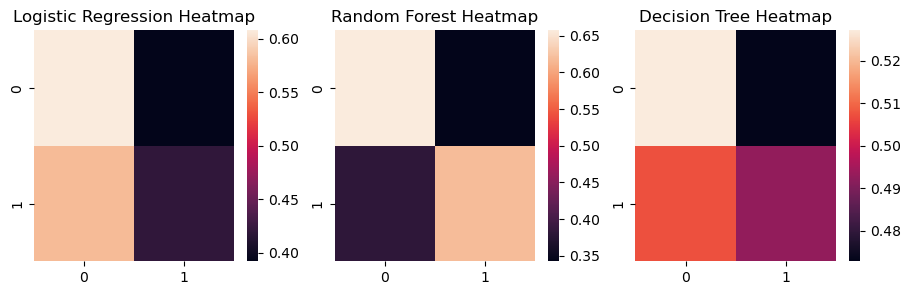

In [51]:
plt.figure(figsize=(11,3))

plt.subplot(131)
sns.heatmap(confusion_matrix(y_test,testsResultL,normalize='true'))
plt.title("Logistic Regression Heatmap")

plt.subplot(132)
sns.heatmap(confusion_matrix(y_test,testsResultRF,normalize='true'))
plt.title("Random Forest Heatmap")

plt.subplot(133)
sns.heatmap(confusion_matrix(y_test,testsResultDT,normalize='true'))
plt.title("Decision Tree Heatmap")
plt.show()

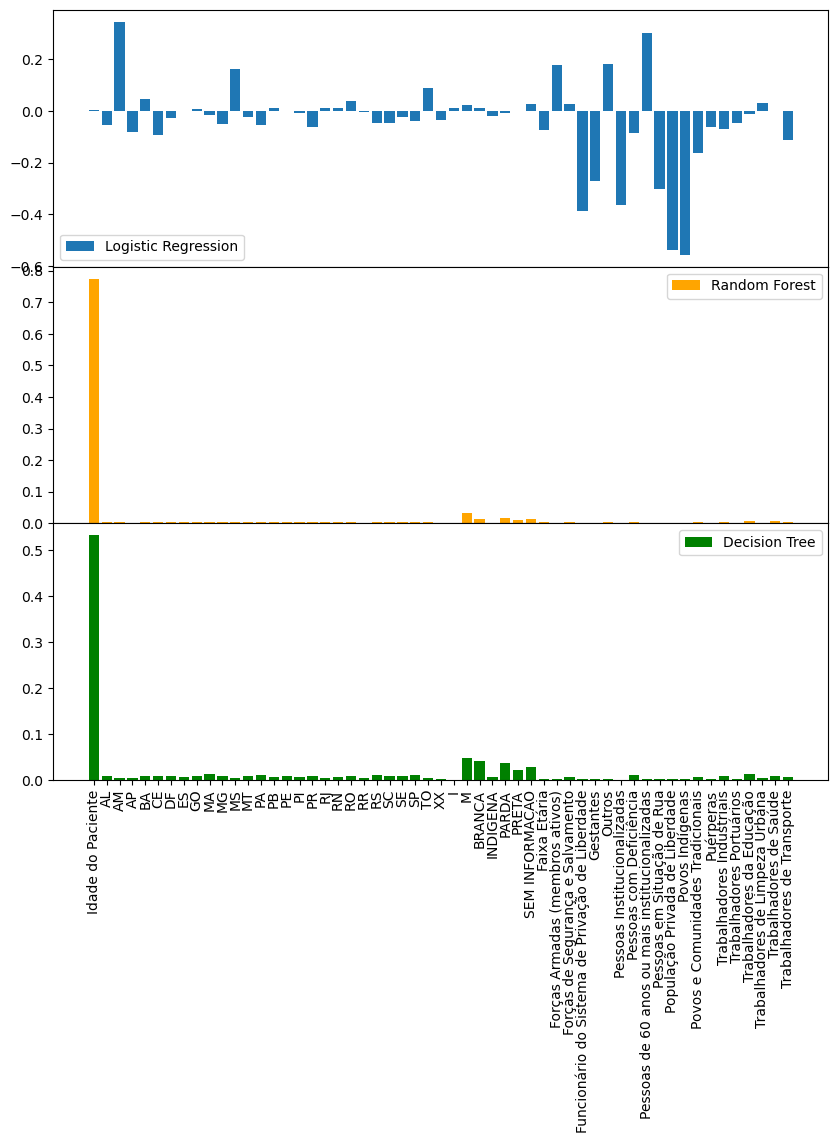

In [52]:
plt.figure(figsize=(10,10))
importance = pd.DataFrame({
    "Logistic Regression" : modelL.coef_[0],
    "Random Forest" : modelRF.feature_importances_,
    "Decision Tree" : modelDT.feature_importances_
},index = x_test.columns)

plt.subplots_adjust(hspace=.0)

plt.subplot(311)
plt.bar(x_test.columns,modelL.coef_[0], label="Logistic Regression")
plt.legend()
plt.xticks([])

plt.subplot(312)
plt.bar(x_test.columns,modelRF.feature_importances_, label="Random Forest", color='orange')
plt.legend()
plt.xticks([])

plt.subplot(313)
plt.bar(x_test.columns,modelDT.feature_importances_, label="Decision Tree",color='green')
plt.legend()
plt.xticks(rotation=90)


plt.show()

### `CONCLUSAO`:

Podemos concluir que o para um mesmo banco de dados, diferentes modelos terão diferentes resultados e que, para diferentes perguntas, cada modelo pode ser mais ou menos efetivo. Dessa forma, foi criado um experimento mais prático para tornar mais tangivel o entendimento dos modelos.                                                                                                                                         
Assim:

#### Insira as informações na celula `abaixo`

In [53]:
print('Insira as  features do suposto cidadão:')


Insira as  features do suposto cidadão:


In [54]:
x_test.columns

Index(['Idade do Paciente', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO',
       'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO',
       'RR', 'RS', 'SC', 'SE', 'SP', 'TO', 'XX', 'I', 'M', 'BRANCA',
       'INDIGENA', 'PARDA', 'PRETA', 'SEM INFORMACAO', 'Faixa Etária',
       'Forças Armadas (membros ativos)', 'Forças de Segurança e Salvamento',
       'Funcionário do Sistema de Privação de Liberdade', 'Gestantes',
       'Outros', 'Pessoas Institucionalizadas', 'Pessoas com Deficiência',
       'Pessoas de 60 anos ou mais institucionalizadas',
       'Pessoas em Situação de Rua', 'População Privada de Liberdade',
       'Povos Indígenas', 'Povos e Comunidades Tradicionais', 'Puérperas',
       'Trabalhadores Industriais', 'Trabalhadores Portuários',
       'Trabalhadores da Educação', 'Trabalhadores de Limpeza Urbana',
       'Trabalhadores de Saúde', 'Trabalhadores de Transporte'],
      dtype='object')

- Features:\
UF\ ->  'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO',
       'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO',
       'RR', 'RS', 'SC', 'SE', 'SP', 'TO'                                                                                                        
Idade\
Raça/cor - > AMARELA, BRANCA, INDIGENA, PARDA, PRETA                                                                                            
Sexo - F,M 


In [65]:
uf = input('Insira a UF do seu suposto cidadão:')
idade = int(input('Insira a idade do seu suposto cidadão:'))
raca = input('Insira a raça do seu suposto cidadão:')
sexo = input('Insira a sexo do seu suposto cidadão:')

df_teste_usuario = pd.DataFrame({
    'UF':uf, 
    'Idade':idade,
    'Raça': raca,
    'Sexo': sexo})

ValueError: If using all scalar values, you must pass an index

In [62]:
display(df_teste_usuario)

NameError: name 'df_teste_usuario' is not defined

In [60]:
testsResultL = modelL.predict(df_teste_usuario)  # Modelo Logístico
testsResultRF = modelRF.predict(df_teste_usuario)  # Random Forest
testsResultDT = modelDT.predict(df_teste_usuario)  # Decision Tree

NameError: name 'df_teste_usuario' is not defined

In [61]:
display(testsResultL)
display(testsResultRF)
display(testsResultDT)

array([ True, False, False, ..., False, False, False])

array([False,  True,  True, ..., False, False, False])

array([ True, False, False, ..., False,  True,  True])